# Imports

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
from scipy.integrate import quad
import time
import re
import os
from sklearn.linear_model import LinearRegression
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from typing import List, Dict, Any, Tuple, Pattern
from scipy.signal import find_peaks

In [139]:
%matplotlib
plt.ion()

Using matplotlib backend: module://matplotlib_inline.backend_inline


# Useful custom defs

## defs

In [166]:
def dir_match(path: str, pattern: Pattern[str]) -> list[str]:
    """
    Iterates through contents of dir and matches according to some regex pattern

    Args:
        path (str): path to directory of interest
        pattern (str): pattern to find, either simple or regex
    
    Returns:
        list[str]: All matches
    """
    matched = []
    dir_contents = sorted(os.listdir(path))
    for item in dir_contents:
        if re.match(pattern, item) is not None:
            matched.append(item)
    return matched

def subtract_hex(n1: str, n2: str) -> str:
    """
    Does subtraction in hex

    Args:
        n1 (str): First number as a string
        n2 (str): Second number as a string
    
    Returns:
        str: a hex subtraction
    """
    h1 = int(n1, 16)
    h2 = int(n2,16)
    return hex(abs(h1-h2))

def sum_hex(n1: str, n2: str) -> str:
    """
    Sums two numbers in hex

    Args:
        n1 (str): First number as a string
        n2 (str): Second number as a string
    
    Returns:
        str: a hex subtraction
    """
    h1 = int(n1, 16)
    h2 = int(n2, 16)
    return hex(h1+h2)

def get_wavenumber(unit1: float, units1: List[float], units2: List[float]) -> List[float]:
    """
    Converts `unit1` to `unit2` based on the
    `sklearn.linear_model.LinearRegression()`
    fit of lists `units1` and `units2`

    Args:
        unit1 (float): Value in the unit of interest (unit to which will convert)
        units1 (list[float]): List of values in units of interest
        units2 (list[float]): List of values in units from which we are converting
    
    Returns:
        List[float]: Value in units of interest, slope, intercept
    """
    lr_wavenumbers = LinearRegression()
    offset_arr = np.array(units1).reshape(-1, 1)
    wavnumber_arr = np.array(units2).reshape(-1, 1)
    lr_wavenumbers.fit(offset_arr, wavnumber_arr)
    a = float(lr_wavenumbers.coef_[0][0])
    b = float(lr_wavenumbers.intercept_[0]) # type: ignore
    return [a*unit1 + b, a, b]


def get_modamp_around_line_in_wav(modamps: List[str], line_in_offsets: float, conversion_params: Tuple[float, float]) -> List[float]:
    """
    Effectively converts modulation amplitude
    from LabView hexes to [somewhat] actual wavenumbers cm-1

    Args:
        modamps (List[str]): Gives a list of modamps as hex strings (w/0 '0x' prepended)
        line_in_offsets (float): Line position in offsets (decimal)
    
    Returns:
        List[float]: Modulation amplitudes in wavenumbers cm-1

    """
    amp_wav_list = []
    for amp in modamps:
        offset = int(f"0x{amp}", 16)
        left_bound = line_in_offsets - offset/2
        right_bound = line_in_offsets + offset/2
        left_bound = conversion_params[1]*left_bound + conversion_params[2] # type: ignore
        right_bound = conversion_params[1]*right_bound + conversion_params[2] # type: ignore
        mod_amp = left_bound - right_bound
        amp_wav_list.append(mod_amp)
    return amp_wav_list

def amp_test_plot(pressure_string: str | int, path: str, amp_test_dict: Dict, used_amps: List[str]|List[int], vlinepos: float, ow_params: List[List[float]]) -> None:
    """
    Do some parameter tests on specific line,
    For example, plot a line with different laser
    power/current modulation amplitudes or modulation frequencies

    Args:
        pressure_string (str | int): used to retrieve data according to pressure in filename
        path (str): used for underlying `CEPAS_measurement()` call
        ampt_test_dict (Dict): Just an empty dict, in which all used measurements are supposed to be stored (created globally before call)
        ow_params (Tuple[List[float], List[float]]): 
        vlinepos (float): argument which can be useful with `ipywidgets.interact`-ish calls to find some positions
    
    Returns:
        None: Just plots multiple plots on top of each other, with legend of different parameters used
    """
    plt.figure(figsize=(10, 10))
    for i in used_amps:
        # auto_freq_test[f'cm{i}_fl'] = CEPAS_measurement(path=path2, path_signature=f"gasx_600_51_{i}__msr__", cols=col_names)
        amp_test_dict[f'cm{i}_fl'] = CEPAS_measurement(path=path, path_signature=f"gasx_{pressure_string}_{i}_20__msr__", cols=col_names) # type: ignore
        amp_test_dict[f'cm{i}_fl'].spectra_list[0]['wav'] = get_wavenumber(amp_test_dict[f'cm{i}_fl'].spectra_list[0]['offset1'], ow_params[0], ow_params[1]) # type: ignore
        # auto_test[f'cm{i}_fl'].water_plot()
        # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[0]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[0]['RH'], label=f"{i}")
        # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[1]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[1]['RH'], label=f"{i}")
        # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[2]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[2]['RH'], label=f"{i}")
        min_val = abs(amp_test_dict[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].min())
        max_val = abs(amp_test_dict[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].max())
        ratio = max_val / min_val
        plt.plot(amp_test_dict[f'cm{i}_fl'].spectra_list[0]['wav'], amp_test_dict[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'], label=f'Amplitude = {i}, PTR={ratio:.2f}')
    plt.legend(loc=2)
    plt.vlines(vlinepos, ymin=-5, ymax=7, colors=['red'])
    plt.title(f"{pressure_string} mbar")
    plt.show()

auto_freq_test_300 = {}
auto_amp_test_300 = {}

## tests

In [141]:
path = './datas/full_tests/'
path2 = './datas/freq_tests/1/'
freq_list = [20, 32, 42, 74, 98, 130, 171, 227, 300]
for i in freq_list:
    test_pattern = re.compile(f".+600_51_{i}.+")
    print(dir_match(path2, test_pattern))

['gasx_600_51_20__msr__0', 'gasx_600_51_20__msr__1', 'gasx_600_51_20__msr__2']
['gasx_600_51_32__msr__3', 'gasx_600_51_32__msr__4', 'gasx_600_51_32__msr__5']
['gasx_600_51_42__msr__6', 'gasx_600_51_42__msr__7', 'gasx_600_51_42__msr__8']
['gasx_600_51_74__msr__10', 'gasx_600_51_74__msr__11', 'gasx_600_51_74__msr__9']
['gasx_600_51_98__msr__12', 'gasx_600_51_98__msr__13', 'gasx_600_51_98__msr__14']
['gasx_600_51_130__msr__15', 'gasx_600_51_130__msr__16', 'gasx_600_51_130__msr__17']
['gasx_600_51_171__msr__18', 'gasx_600_51_171__msr__19', 'gasx_600_51_171__msr__20']
['gasx_600_51_227__msr__21', 'gasx_600_51_227__msr__22', 'gasx_600_51_227__msr__23']
['gasx_600_51_300__msr__24', 'gasx_600_51_300__msr__25', 'gasx_600_51_300__msr__26']


# For analysis

## 16.05.2025 Single point test data analysis

/tmp/ipykernel_1085/2168176887.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  single_point_test = pd.read_csv("./datas/point_tests/point0", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)


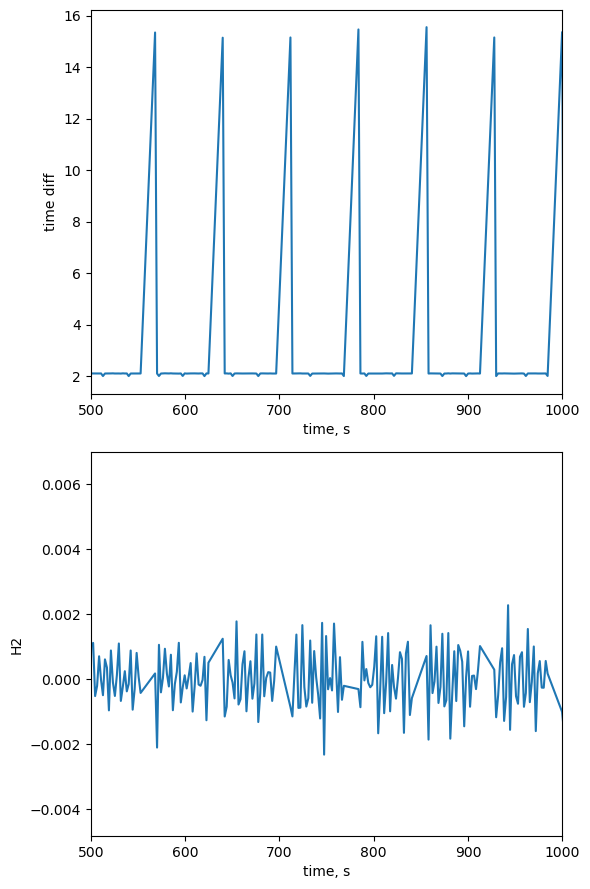

In [142]:
col_names = {
    0: 'time',          # time (measurement tick, stopped on gasx, arbitrary)
    1: 'offset1',       # DFB offset-1
    2: 'P1',            # onboard pressure sensor (blue tube)
    3: 'H3',            # 3rd harmonic (L1H1)
    4: 'H2',            # 2nd harmonic (L1H2)
    5: 'P_las',         # laser power (some volts)
    6: 'T_las',         # diode temp (Kelvin)
    7: 'RH',            # humidity sensor (external)
    8: 'Pressure'       # sensor (external)
}

single_point_test = pd.read_csv("./datas/point_tests/point0", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)
single_point_test_gasx = pd.read_csv("./datas/point_tests/point_gasx_2", sep=r'\s+', header=None, names=list(col_names.values()), index_col=False)



df_single_diff = single_point_test_gasx.iloc[1:,:].copy().diff(axis=0, periods=1)
df_single = single_point_test_gasx.iloc[1:,:].copy()

# df_single['time'] -= df_single['time'].min()
plt.figure(figsize=(6, 9))
plt.subplot(211)
plt.plot(df_single['time'], df_single_diff['time'])
# plt.hlines(y=[df_single_diff['H2'].mean(), df_single_diff['H2'].mean() - df_single_diff['H2'].std(), df_single_diff['H2'].mean() + df_single_diff['H2'].std()], xmin=0, xmax=4000, colors=['black', 'red', 'red'])
plt.xlim(500, 1000)
plt.xlabel("time, s")
plt.ylabel("time diff")

plt.subplot(212)
plt.plot(df_single['time'], df_single_diff['H2'])
# plt.hlines(y=[df_single_diff['H2'].mean(), df_single_diff['H2'].mean() - df_single_diff['H2'].std(), df_single_diff['H2'].mean() + df_single_diff['H2'].std()], xmin=0, xmax=4000, colors=['black', 'red', 'red'])
plt.xlim(500, 1000)
plt.xlabel("time, s")
plt.ylabel("H2")

plt.tight_layout()
plt.show()

## Measurement visualization class

In [143]:
class CEPAS_measurement():

    def __init__(self, path: str, path_signature: str | Pattern[str], cols: Dict[int, str]) -> None:
        """
        Initialize measurement from csv file to do data anlysis in python (pandas, numpy etc.)
        Collects all measurement files according to specified `path` and `path_signature`.
        collects all specified spectra in attribute `spectra_list`
        Adds `time_subtracted` column and `_pnorm` power normalized columns.
        Add 2 peaks of interest to see them up close in subplots.

        Args:
            path (str): pass a path where spectra measurement files are located
            path_signature (str | Pattern[str]): pass a string or pattern to use as regex to find files
            cols (Dict[int, str]): pass a dict of columns to use as new column names
        
        Returns:
            None: but creates attributes
        """    
        self.path = path
        self.raw_spectra = [pd.read_csv(path+self.dir_match(path_signature)[i], sep=r'\s+', header=None, names=list(cols.values()), index_col=False) for i in range(len(self.dir_match(path_signature)))]

        self.spectra_list = [self.raw_spectra[i].iloc[1:,:].copy() for i, _ in enumerate(self.raw_spectra)]
        for df_idx in range(len(self.spectra_list)):
            self.spectra_list[df_idx].loc[:,'time_subtracted'] = self.spectra_list[df_idx]['time']           
            self.spectra_list[df_idx].loc[:,'time_subtracted'] -= self.spectra_list[df_idx]['time'].min()
            self.spectra_list[df_idx].loc[:,'H2_pnorm'] = self.spectra_list[df_idx].loc[:,'H2'] / (self.spectra_list[df_idx].loc[:,'P_las']+0.0025)
            self.spectra_list[df_idx].loc[:,'H3_pnorm'] = self.spectra_list[df_idx].loc[:,'H3'] / (self.spectra_list[df_idx].loc[:,'P_las']+0.0025)

        self.mean_humidities = {df_idx: self.spectra_list[df_idx]['RH'].mean() for df_idx in range(len(self.spectra_list))}
        self.mean_humidities_norm = np.array(list(self.mean_humidities.values()))/np.array(list(self.mean_humidities.values())).max()
        # self.mean_humidities_norm = None

        # peak 1 idx 40-70
        self.peak_1s = [self.spectra_list[i].loc[40:70,:]['H2'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_1s_norm = [self.spectra_list[i].loc[40:70,:]['H2_pnorm'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_1s_norm_mins = [self.spectra_list[i].loc[40:70,:]['H2_pnorm'].min() for i, _ in enumerate(self.spectra_list)]
        self.ylim_11 = np.array(self.peak_1s_norm_mins).min() - 0.1
        self.ylim_12 = np.array(self.peak_1s_norm).max() + 0.1

        # peak 2 idx 150-175
        self.peak_2s = [self.spectra_list[i].loc[150:175,:]['H2'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_2s_norm = [self.spectra_list[i].loc[150:175,:]['H2_pnorm'].max() for i, _ in enumerate(self.spectra_list)]
        self.peak_2s_norm_mins = [self.spectra_list[i].loc[150:175,:]['H2_pnorm'].min() for i, _ in enumerate(self.spectra_list)]
        self.ylim_21 = np.array(self.peak_2s_norm_mins).min() - 0.1
        self.ylim_22 = np.array(self.peak_2s_norm).max() + 0.1

        self.pressures = [self.spectra_list[i]['Pressure'].unique() for i, _ in enumerate(self.spectra_list)]
    
    def water_plot(self, save: bool=False, save_path: str="./water_plot_default.svg") -> None:
        """
        Creates a plot with full spectrum,
        two peaks of choice,their intensities across measurements
        and normalized relative humidity across measurements

        Args:
            save (bool): save or not to save
            save_path: where to save
        Returns:
            None: but saves fig if specified!
        """
        fig = plt.figure(figsize=(17, 11))  # noqa: F841

        ax0 = plt.subplot2grid(shape=(12, 12), loc=(6, 0), colspan=6, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax0.plot(self.spectra_list[df_idx]['offset1'], self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        # ax0.set_xlim()
        # ax0.set_ylim(-0.5, 1)
        ax0.set_title("Power normalized spectrum")
        ax0.legend()
        ax0.set_xlabel("Arbitrary index")
        # ax0.set_xlabel("Laser current, arbitrary units")

        ax1 = plt.subplot2grid(shape=(12, 12), loc=(0, 6), colspan=5, rowspan=4)
        ax1.scatter(list(self.mean_humidities.keys()), self.mean_humidities_norm)
        ax1.set_xlabel('measurement #')
        ax1.set_ylabel('mean relative humidity, %')
        ax1.set_title("relative humidity over different measurement sessions")

        ax2 = plt.subplot2grid(shape=(12, 12), loc=(4, 6), colspan=5, rowspan=4)
        plt.scatter(list(range(len(self.peak_1s_norm))), self.peak_1s_norm)
        ax2.set_title("Peak 1 over sessions")
        ax2.set_xlabel("measurement #")
        ax2.set_ylabel("Normalized peak intensity")

        ax3 = plt.subplot2grid(shape=(12, 12), loc=(8, 6), colspan=5, rowspan=4)
        ax3.scatter(list(range(len(self.peak_2s_norm))), self.peak_2s_norm)
        ax3.set_title("Peak 2 over sessions")
        ax3.set_xlabel("measurement #")
        ax3.set_ylabel("Normalized peak intensity")



        ax4 = plt.subplot2grid(shape=(12, 12), loc=(0, 0), colspan=3, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax4.plot(self.spectra_list[df_idx]['offset1'], self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        ax4.set_xlim(40, 75) # x=index
        ax4.set_ylim(self.ylim_11, self.ylim_12)
        ax4.set_title("Peak 1")
        ax4.legend()
        # plt.xlabel("time, s")
        ax4.set_xlabel("arbitrary index")

        ax5 = plt.subplot2grid(shape=(12, 12), loc=(0, 3), colspan=3, rowspan=6)
        for df_idx in range(len(self.spectra_list)):
            ax5.plot(self.spectra_list[df_idx]['offset1'], self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        ax5.set_xlim(142, 182) # x=index
        ax5.set_ylim(self.ylim_21, self.ylim_22)
        ax5.set_title("Peak 2")
        ax5.legend()
        # plt.xlabel("time, s")
        ax4.set_xlabel("arbitrary index")

        plt.tight_layout()
        plt.show()

        if save:
            plt.savefig(f"{save_path}")

    def spectrum_only_plot(self, save: bool=False, save_path: str="./spectrum_only_plot_default.svg") -> None:
        """
        Makes just a simple plot of spectrum with all measurements
        laid over each other

        Args:
            save (bool): save or not to save
            save_path: where to save
        Returns:
            None: but saves fig if specified!
        """
        fig = plt.figure(figsize=(17, 5.5))  # noqa: F841

        ax0 = plt.subplot2grid(shape=(12, 12), loc=(0, 0), colspan=12, rowspan=12)
        for df_idx in range(len(self.spectra_list)):
            ax0.plot(self.spectra_list[df_idx]['offset1'], self.spectra_list[df_idx]['H2_pnorm'], label=f"{df_idx}")
        # ax0.set_xlim()
        # ax0.set_ylim(-0.5, 1)
        ax0.set_title("Power normalized spectrum")
        ax0.legend()
        ax0.set_xlabel("Arbitrary index")
        

        plt.tight_layout()
        plt.show()

        if save:
            plt.savefig(f"{save_path}")


    def dir_match(self, pattern: str | Pattern[str]) -> List[str]:
        """
        Iterates through contents of dir and matches according to some regex pattern

        Args:
            path (str): path to directory of interest
            pattern (str): pattern to find, either simple or regex
        
        Returns:
            list[str]: All matches
        """
        matched = []
        dir_contents = sorted(os.listdir(self.path))
        for item in dir_contents:
            if re.match(pattern, item) is not None:
                matched.append(item)
        return matched

# $p_{cell}\approx300\ \text{[mbar]}$

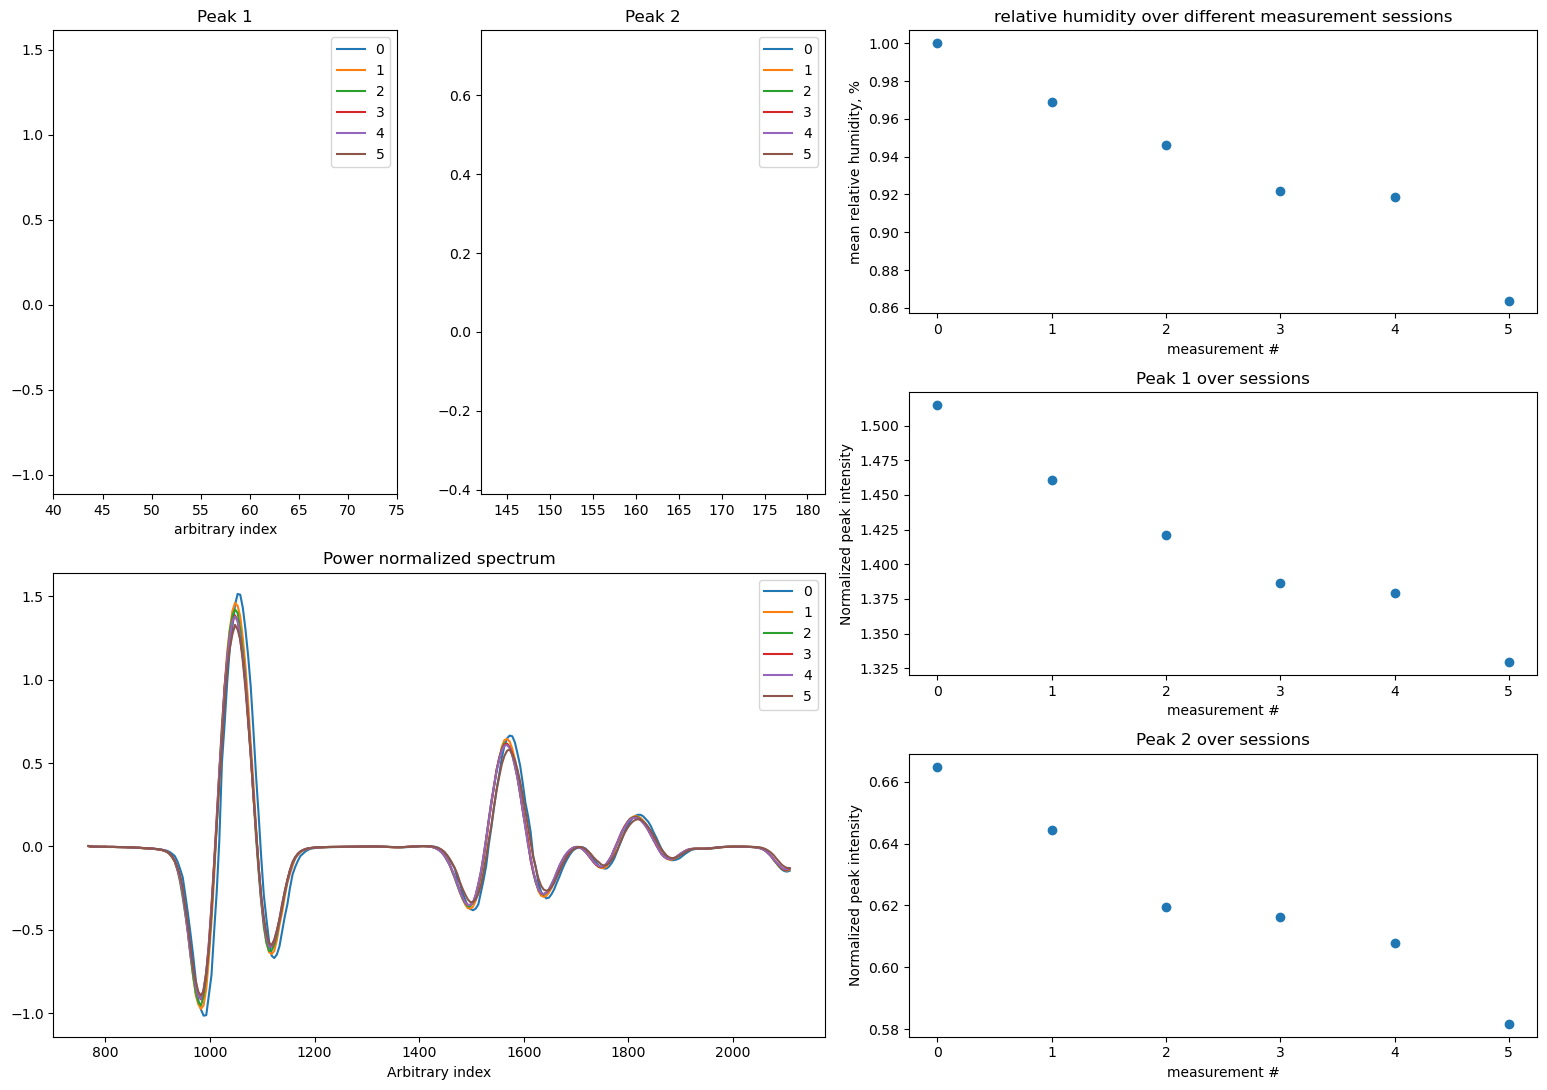

In [144]:
path_sig = "gasx2__msr__"
cm1 = CEPAS_measurement(path, path_sig, col_names)
cm1.water_plot()

# $p_{cell}\approx600\ \text{[mbar]}$

After closer inspection, seems like in these measurements the power meter was not turned on, so the power normalization is just wrong here

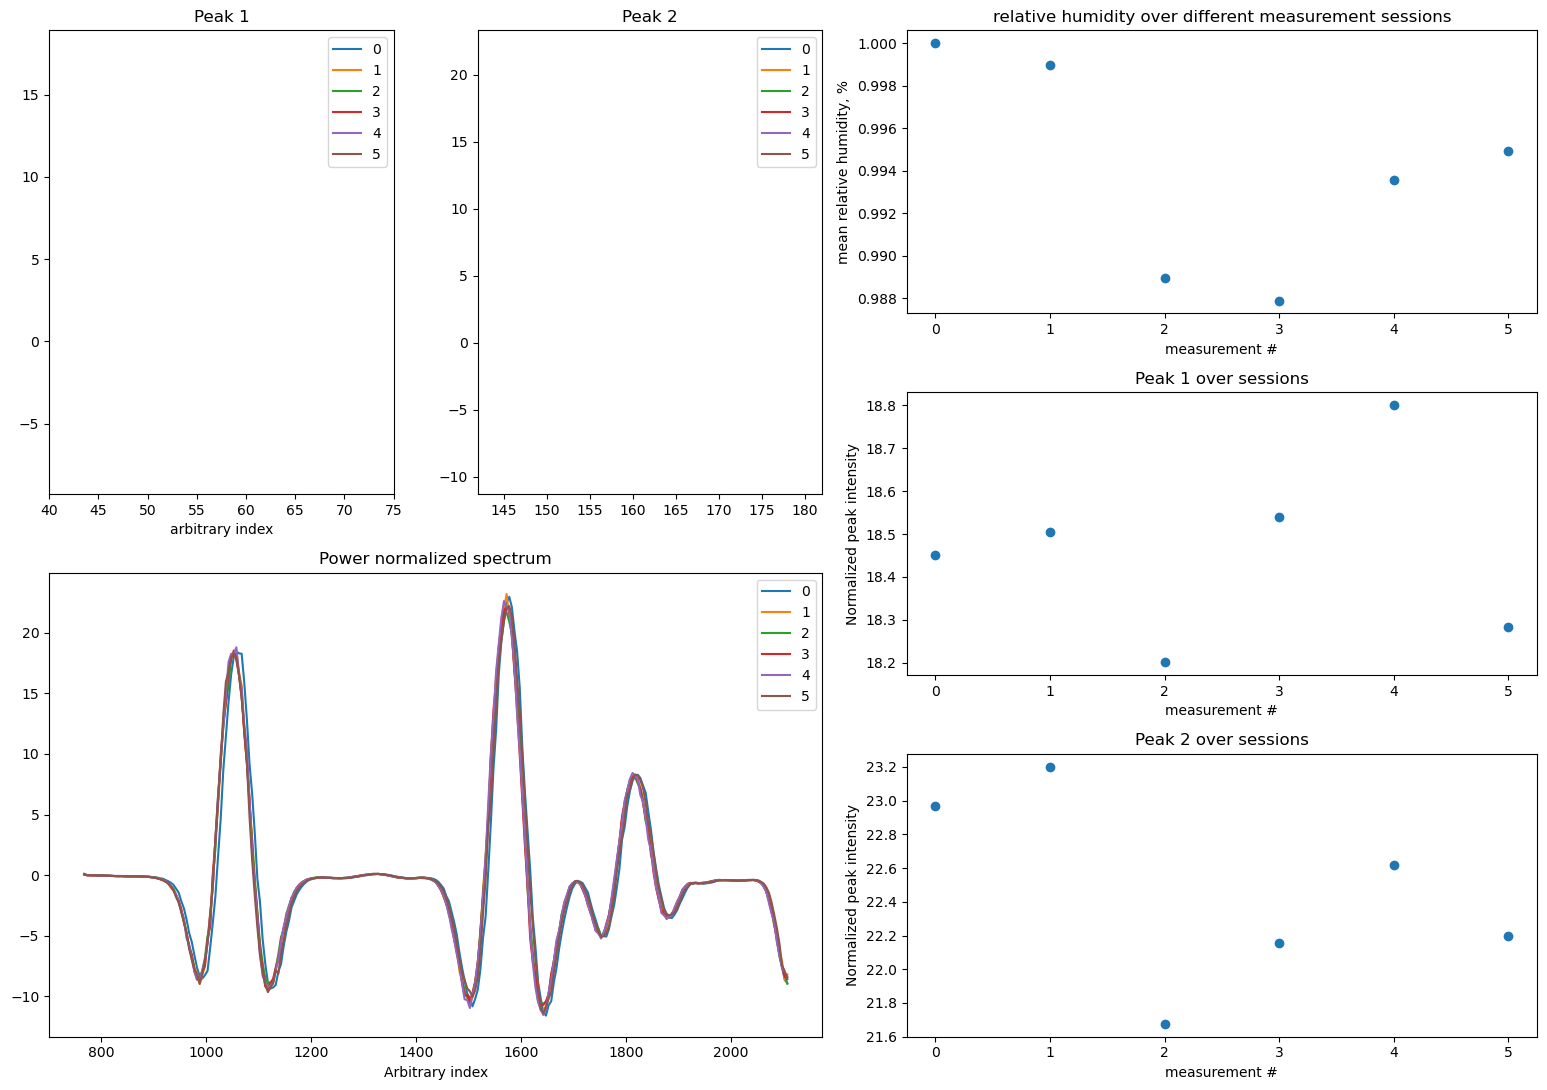

In [145]:
path_sig = "gasx600mbar__msr__"
cm2 = CEPAS_measurement(path, path_sig, col_names)
cm2.water_plot()

In [146]:
cm2.spectra_list[0]

,time,offset1,P1,H3,H2,P_las,T_las,RH,Pressure,time_subtracted,H2_pnorm,H3_pnorm
1,2720.914,768.0,0.0,-0.000061,2.726311e-05,-0.001233,292.2455,40.20996,600.0,0.000,0.021520,-0.047832
2,2723.023,773.0,0.0,0.000067,9.624281e-06,-0.001233,292.2383,40.20996,600.0,2.109,0.007597,0.052638
3,2725.132,778.0,0.0,-0.000015,3.086489e-06,-0.001226,292.2392,40.18555,600.0,4.218,0.002423,-0.011454
4,2727.237,783.0,0.0,0.000002,9.410022e-07,-0.001219,292.2385,40.18555,600.0,6.323,0.000735,0.001475
5,2729.340,788.0,0.0,0.000045,1.849333e-06,-0.001238,292.2407,40.16113,600.0,8.426,0.001465,0.035961
...,...,...,...,...,...,...,...,...,...,...,...,...
265,3384.542,2088.0,0.0,0.000987,-6.414715e-03,-0.001249,292.2231,40.25879,595.0,663.628,-5.127629,0.789028
266,3386.646,2093.0,0.0,0.001334,-8.102135e-03,-0.001269,292.2290,40.30762,595.0,665.732,-6.583943,1.084011
267,3388.751,2098.0,0.0,0.001813,-9.388976e-03,-0.001260,292.2339,40.30762,595.0,667.837,-7.573795,1.462784
268,3390.860,2103.0,0.0,0.001807,-1.076885e-02,-0.001251,292.2345,40.30762,595.0,669.946,-8.623766,1.446961


# Amplitude effects (@ $900\ [\text{mbar}]$) [0x20 too low, 0x66 optimal, 0x108 too high]

## Amplitude = 0x20

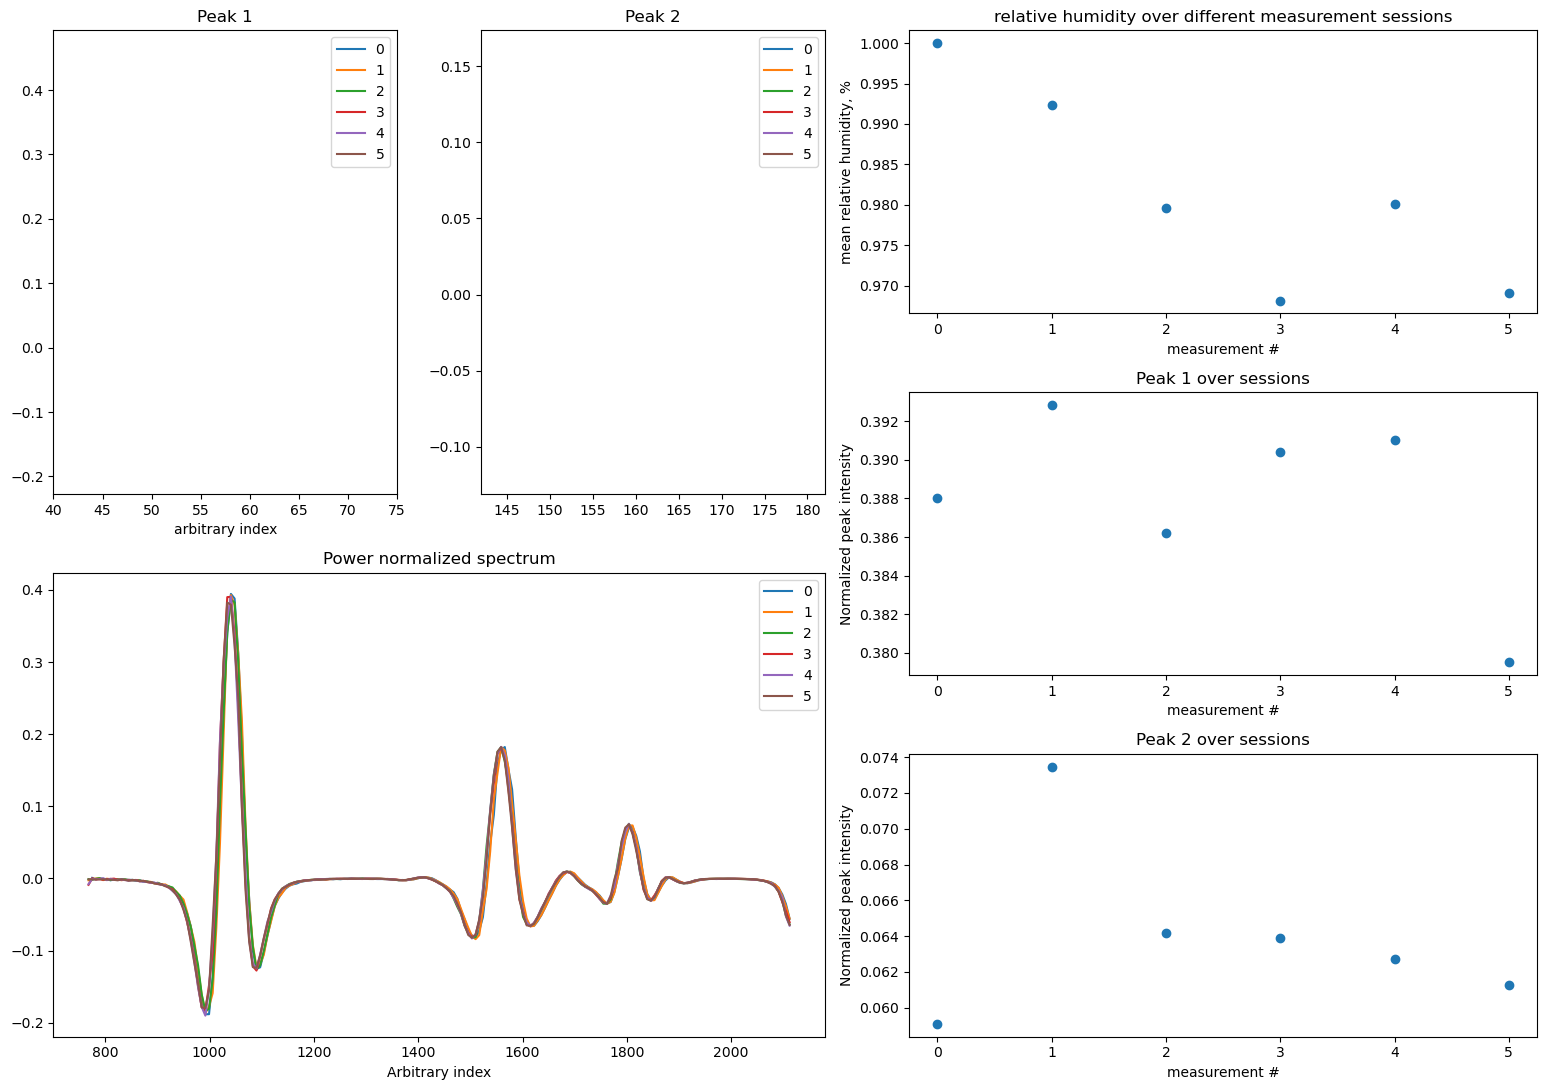

In [147]:
path_sig = "gasx900mbar20amp__msr__"
cm3 = CEPAS_measurement(path, path_sig, col_names)
# len(cm3.spectra_list[0].columns)
cm3.water_plot()


## Amplitude = 66

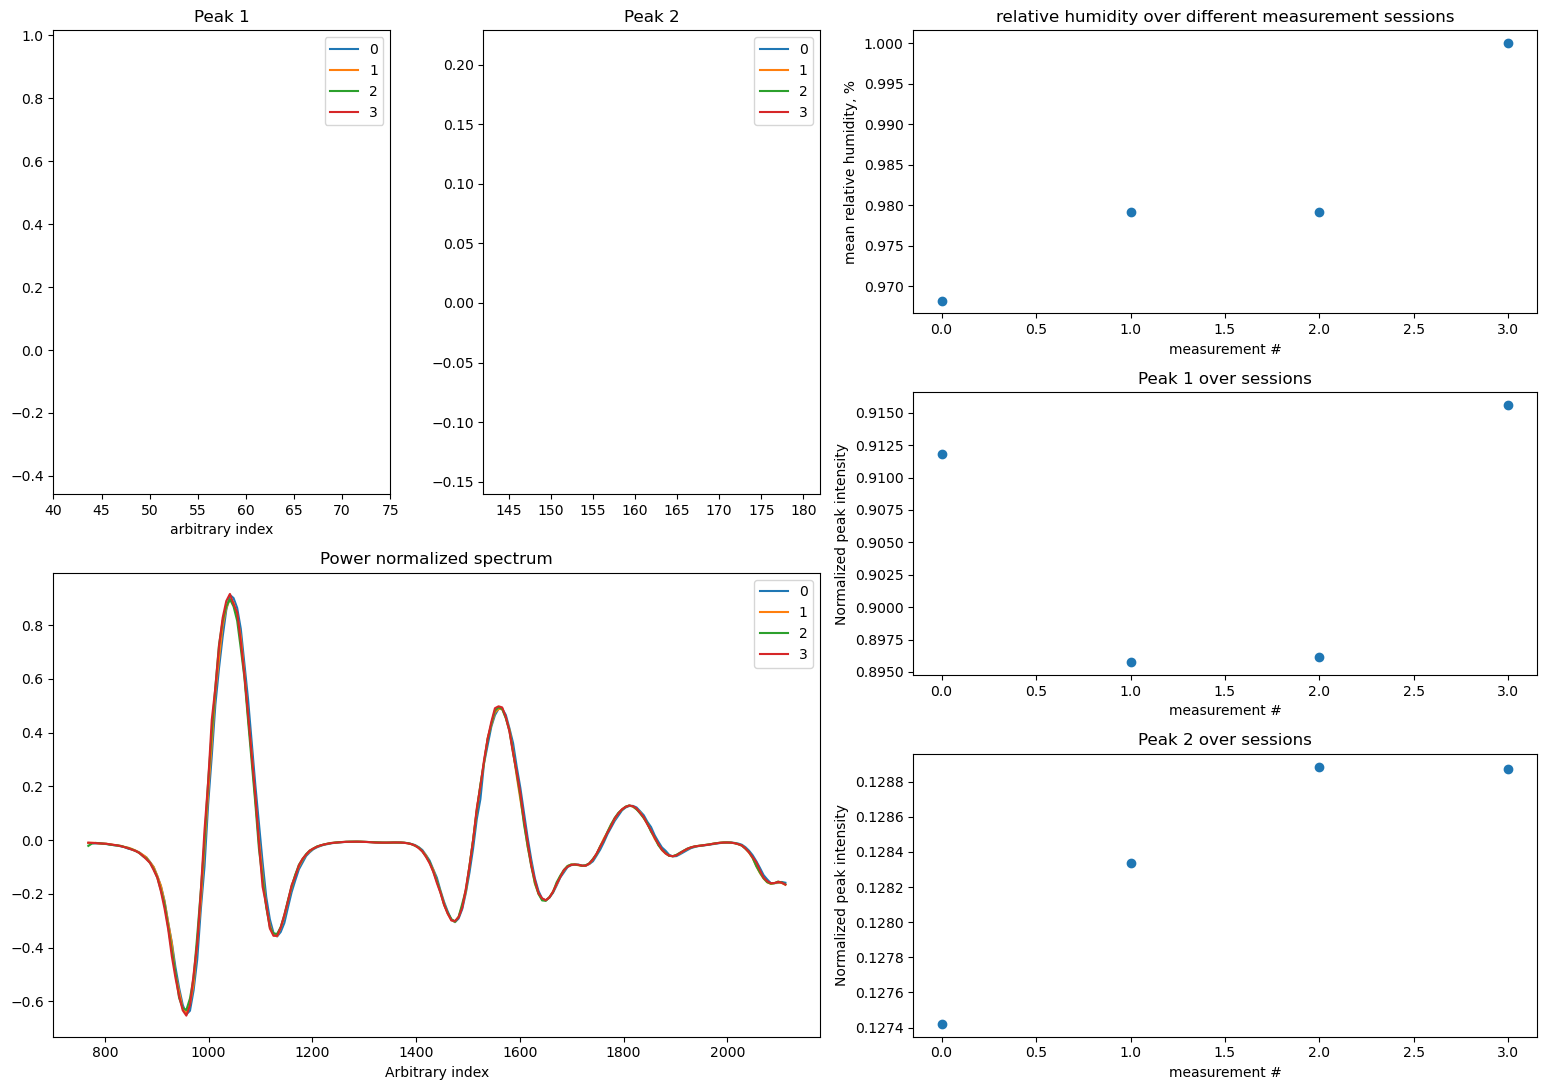

In [148]:
path_sig = "gasx900mbar66amp__msr__"
cm4 = CEPAS_measurement(path, path_sig, col_names)
cm4.water_plot()

## Amplitude 106

In [149]:
path_sig = "gasx900mbar106amp__msr__"
cm5 = CEPAS_measurement(path, path_sig, col_names)
# cm5.water_plot()

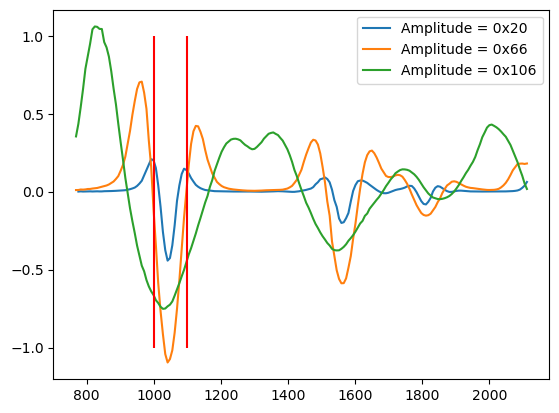

-2.0963459364193224
-1.407104337011501
-0.5346356674952111


In [150]:
plt.plot(cm3.spectra_list[0]["offset1"], cm3.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x20")
plt.plot(cm4.spectra_list[0]["offset1"], cm4.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x66")
plt.plot(cm5.spectra_list[0]["offset1"], cm5.spectra_list[0]["H3_pnorm"], label="Amplitude = 0x106")
# plt.xlim(800, 1200)
plt.vlines([1000, 1100], -1, 1, colors=['red', 'red'])
plt.legend()
plt.show()

print(cm3.spectra_list[0]["H2_pnorm"].max() / cm3.spectra_list[0]["H2_pnorm"].min())
print(cm4.spectra_list[0]["H2_pnorm"].max() / cm4.spectra_list[0]["H2_pnorm"].min())
print(cm5.spectra_list[0]["H2_pnorm"].max() / cm5.spectra_list[0]["H2_pnorm"].min())

## Small amplitude range test

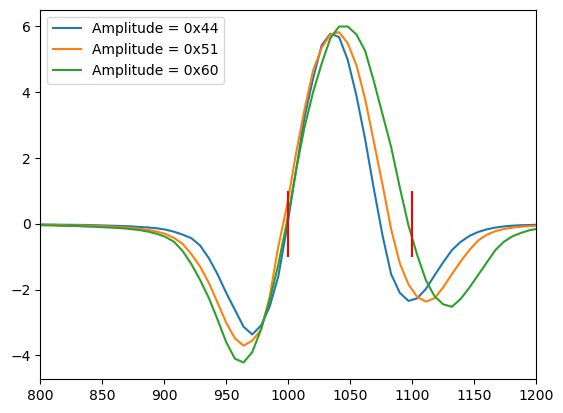

In [151]:
path = './datas/full_tests/'
path_sig = "gasx_600_44_20__msr__"
cm6 = CEPAS_measurement(path, path_sig, col_names)
path_sig = "gasx_600_51_20__msr__"
cm7 = CEPAS_measurement(path, path_sig, col_names)
path_sig = "gasx_600_60_20__msr__"
cm8 = CEPAS_measurement(path, path_sig, col_names)
plt.plot(cm6.spectra_list[0]["offset1"], cm6.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x44")
plt.plot(cm7.spectra_list[0]["offset1"], cm7.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x51")
plt.plot(cm8.spectra_list[0]["offset1"], cm8.spectra_list[0]["H2_pnorm"], label="Amplitude = 0x60")
plt.xlim(800, 1200)
plt.vlines([1000, 1100], -1, 1, colors=['red', 'red'])
plt.legend()
plt.show()

1      False
2      False
3      False
4      False
5      False
       ...  
189    False
190    False
191    False
192    False
193    False
Name: H2_pnorm, Length: 193, dtype: bool


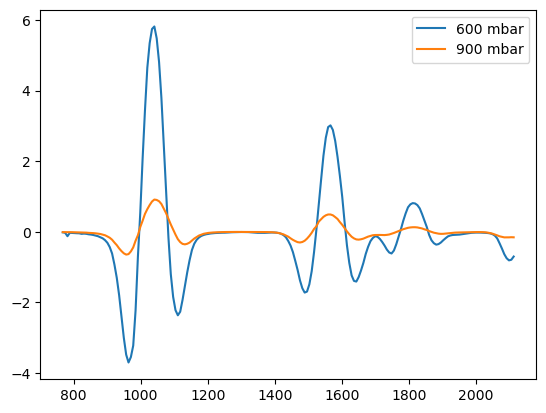

In [152]:
print(cm7.spectra_list[0]["H2_pnorm"] == cm4.spectra_list[0]["H2_pnorm"])
plt.plot(cm7.spectra_list[0]["offset1"], cm7.spectra_list[0]["H2_pnorm"], label="600 mbar")
plt.plot(cm4.spectra_list[0]["offset1"], cm4.spectra_list[0]["H2_pnorm"], label="900 mbar")
plt.legend()
plt.show()


# Auto test

Testing on $\text{H}_2\text{O}$ line in the range

from $6986$ to $6988\ \text{cm}^{-1}$

In [153]:
amp_list = [hex(32+i*8)[2:] for i in range(14)]
print(amp_list)

['20', '28', '30', '38', '40', '48', '50', '58', '60', '68', '70', '78', '80', '88']


In [ ]:
offsets_list_h2o_19_deg = [1503.7818, 976.3011] # add lines from the cepas measurement descending
wavenumbers_list_h2o = [6984.9535, 6987.1444] # add lines from trusted source, like HITRAN ascending

fit_params = get_wavenumber(1, offsets_list_h2o_19_deg, wavenumbers_list_h2o)

offset_wav_dict = dict(zip(amp_list, get_modamp_around_line_in_wav(amp_list, (fit_params[1], fit_params[2]))))
offset_wav_dict

{'20': 0.13291254068644776,
 '28': 0.16614067585760495,
 '30': 0.19936881102967163,
 '38': 0.23259694620173832,
 '40': 0.2658250813728955,
 '48': 0.2990532165440527,
 '50': 0.3322813517152099,
 '58': 0.3655094868872766,
 '60': 0.39873762205934327,
 '68': 0.43196575723050046,
 '70': 0.46519389240165765,
 '78': 0.49842202757372434,
 '80': 0.531650162745791,
 '88': 0.5648782979169482}

In [163]:
path3 = './datas/amptests/1/'
amp_list = [hex(i) for i in range(8, 8*14, 8)] 



amp_test_plot("300", path3, auto_amp_test_300, amp_list, 6987.285, ow_params=[offsets_list_h2o_19_deg, wavenumbers_list_h2o])

ValueError: zero-size array to reduction operation maximum which has no identity

<Figure size 1000x1000 with 0 Axes>

In [ ]:
path4 = "./datas/amptests/2/"
auto_amp_test_600 = {}


interact_manual(
    amp_test_plot,
    pressure_string=fixed("600"),
    path=fixed(path4),
    amp_test_dict=fixed(auto_amp_test_600),
    used_amps=fixed(amp_list),
    vlinepos=(6986.0, 6987.6, 0.004),
    ow_params=fixed(set(offsets_list_h2o_19_deg, wavenumbers_list_h2o))
) 
# amp_test_plot(path4, auto_amp_test_600, amp_list, 6987.285)

TypeError: fixed.__init__() takes 2 positional arguments but 3 were given

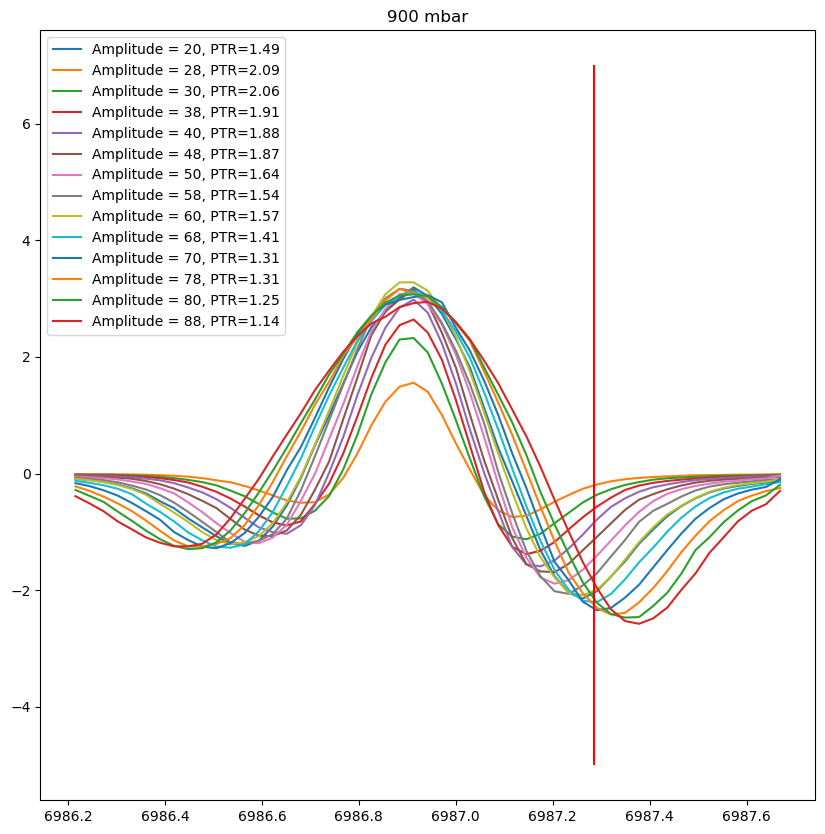

In [ ]:
auto_amp_test_900 = {}
# for i in amp_list:
#     # auto_freq_test[f'cm{i}_fl'] = CEPAS_measurement(path=path2, path_signature=f"gasx_600_51_{i}__msr__", cols=col_names)
#     auto_amp_test_900[f'cm{i}_fl'] = CEPAS_measurement(path=path3, path_signature=f"gasx_900_{i}_20__msr__", cols=col_names)
#     auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['wav'] = get_wavenumber(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['offset1'], offsets_list_h2o_19_deg, wavenumbers_list_h2o)
#     min_val = abs(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].min())
#     max_val = abs(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'].max())
#     ratio = max_val / min_val
#     # auto_test[f'cm{i}_fl'].water_plot()
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[0]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[0]['RH'], label=f"{i}")
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[1]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[1]['RH'], label=f"{i}")
#     # plt.plot(auto_freq_test[f'cm{i}_fl'].spectra_list[2]['time'], auto_freq_test[f'cm{i}_fl'].spectra_list[2]['RH'], label=f"{i}")
#     plt.plot(auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['wav'], auto_amp_test_900[f'cm{i}_fl'].spectra_list[0]['H2_pnorm'], label=f'Amplitude = {i}, PTR={ratio:.2f}')
# plt.legend(loc=1)
# plt.title("900 mbar")
# plt.show()

amp_test_plot("900", path3, auto_amp_test_900, amp_list, 6987.285)

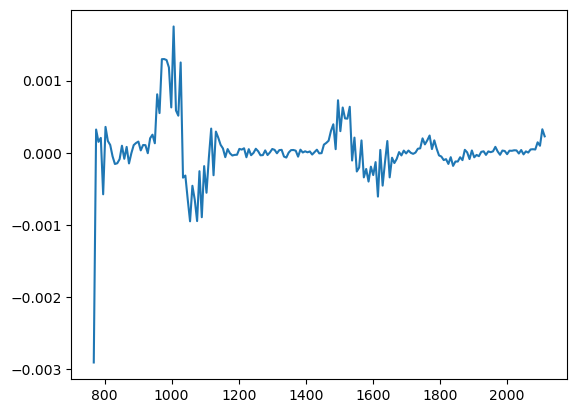

In [ ]:
plt.clf()
cm_last = CEPAS_measurement(path=path2, path_signature="gasx_600_51_300__msr__", cols=col_names)
plt.plot(cm_last.spectra_list[0]['offset1'], cm_last.spectra_list[0]['H3_pnorm'])
plt.show()

# Peak/trough ratio

In [ ]:
auto_amp_tests = {
    '300': auto_amp_test_300,
    '600': auto_amp_test_600,
    '900': auto_amp_test_900
}

def extract_PT_ratios(tests: dict) -> dict:
    for_barplot = {}
    for test in list(tests.keys()):
        print(test)
        for_barplot[test] = {}
        for subtest in tests[test]:
            min_val = abs(tests[test][subtest].spectra_list[0]['H2_pnorm'].min())
            max_val = abs(tests[test][subtest].spectra_list[0]['H2_pnorm'].max())
            ratio = max_val / min_val
            key = f"Amplitude: {subtest}"
            value = ratio
            for_barplot[test][key] = value
    
    return for_barplot

extract_PT_ratios(auto_amp_tests)

300
600
900


{'300': {'Amplitude: cm20_fl': 1.8572713427997576,
  'Amplitude: cm28_fl': 2.0008222960484106,
  'Amplitude: cm30_fl': 1.9438575305495334,
  'Amplitude: cm38_fl': 1.762320889490436,
  'Amplitude: cm40_fl': 1.6506866033833827,
  'Amplitude: cm48_fl': 1.5617129296110441,
  'Amplitude: cm50_fl': 1.3897437074053178,
  'Amplitude: cm58_fl': 1.4184613990501653,
  'Amplitude: cm60_fl': 1.3344244237293932,
  'Amplitude: cm68_fl': 1.2879978759832391,
  'Amplitude: cm70_fl': 1.234607380678039,
  'Amplitude: cm78_fl': 1.1282843521561705,
  'Amplitude: cm80_fl': 1.1276990716844901,
  'Amplitude: cm88_fl': 1.0176601718405858},
 '600': {},
 '900': {'Amplitude: cm20_fl': 1.48986372048321,
  'Amplitude: cm28_fl': 2.0936990056230846,
  'Amplitude: cm30_fl': 2.0649541769237674,
  'Amplitude: cm38_fl': 1.9117654058314861,
  'Amplitude: cm40_fl': 1.8758202287102135,
  'Amplitude: cm48_fl': 1.8704666319656866,
  'Amplitude: cm50_fl': 1.6385571394383918,
  'Amplitude: cm58_fl': 1.5366259549738166,
  'Amplit

# Expt vs Sim analysis

In [ ]:
# rows will be 300-600-900 mbar pressures (implicit)
sim = pd.DataFrame({
    "pressure": [300, 600, 900],
    "pos1": [np.nan, 6987.02, 6986.97],
    "pos2": [6987.13, 6987.13, 6987.13],
    "pos3": [6987.23, 6987.25, 6987.3],
    "amp": [0.083, 0.1, 0.1561]
})

expt = pd.DataFrame({
    "pressure": [300, 600, 900],
    "pos1": [6986.691, 6986.78, 6986.616],
    "pos2": [6986.906, 6987.025, 6986.903],
    "pos3": [6987.128, 6987.29, 6987.193],
    "amp": [offset_wav_dict[i] for i in ['38', '40', '48']]
})

sim

,pressure,pos1,pos2,pos3,amp
0,300,NaN,6987.13,6987.23,0.0830
1,600,6987.02,6987.13,6987.25,0.1000
2,900,6986.97,6987.13,6987.30,0.1561


/tmp/ipykernel_1085/804583558.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc=3)


<Figure size 640x480 with 0 Axes>

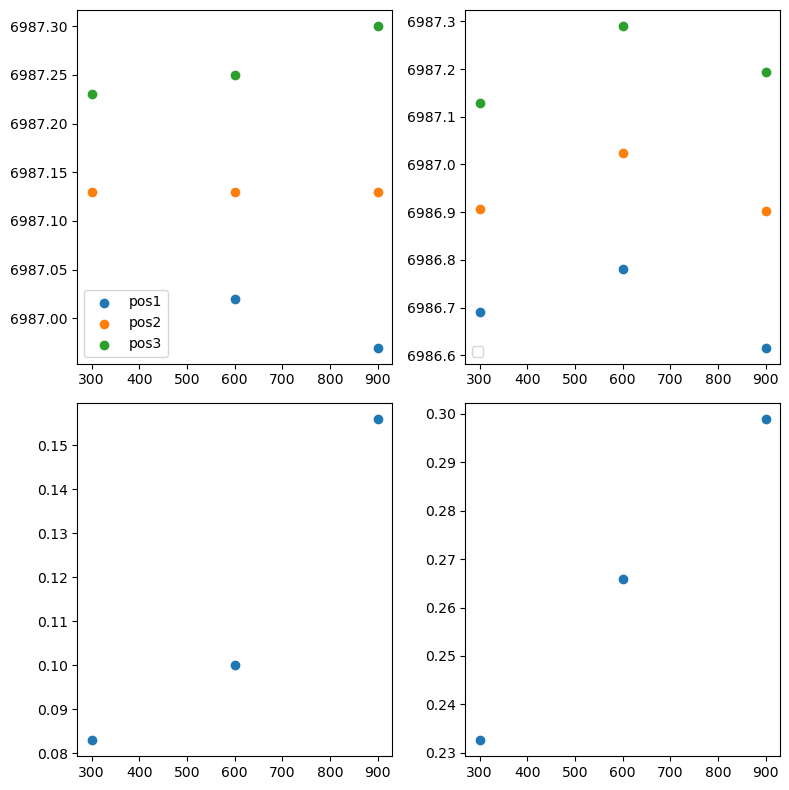

In [ ]:
plt.clf()
fig = plt.figure(figsize=(8, 8))  # noqa: F841

ax0 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1, rowspan=1)
for pos in ['pos1', 'pos2', 'pos3']:
    ax0.scatter(sim['pressure'], sim[pos], label=pos)
ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax0.legend(loc=3)

ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=1, rowspan=1)
ax1.legend(loc=3)
for pos in ['pos1', 'pos2', 'pos3']:
    ax1.scatter(expt['pressure'], expt[pos], label=pos)

ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), rowspan=1, colspan=1)
ax2.scatter(sim['pressure'], sim['amp'])

ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), rowspan=1, colspan=1)
ax3.scatter(expt['pressure'], expt['amp'])

plt.tight_layout()
plt.show()

In [ ]:
r_o_r_expt = (expt['amp'][2] - expt['amp'][0]) / 600
r_o_r_sim = (sim['amp'][2] - sim['amp'][0]) / 600

print(f"ROR expt = {r_o_r_expt}")
print(f"ROR sim  = {r_o_r_sim}")

ROR expt = 0.00011076045057052397
ROR sim  = 0.0001218333333333333


# $22\ \degree\text{C}$ test

## Initial full spectrums in $p_{cell}=\lbrace 300,600,900\rbrace\ \text{[mbar]}$

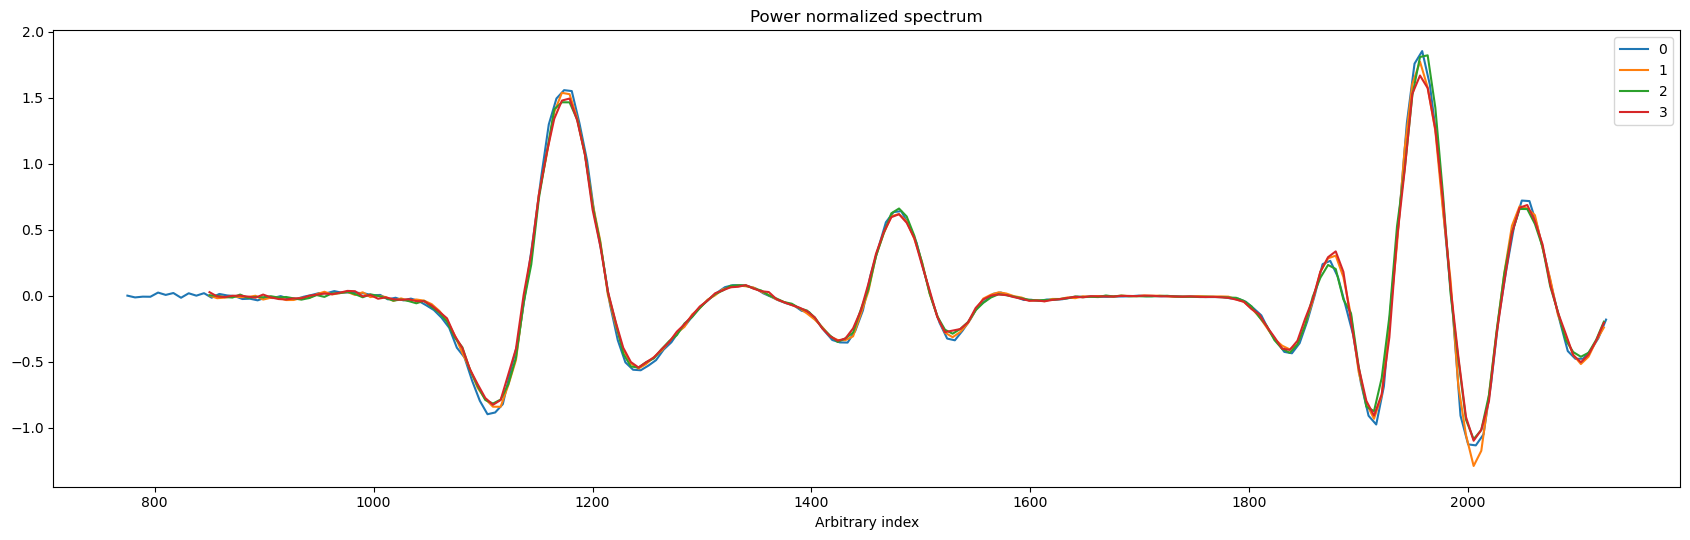

In [ ]:
path_22_deg = "./datas/22deg/"
cm_22deg_300 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_300_.+", cols=col_names)
cm_22deg_300.spectrum_only_plot()

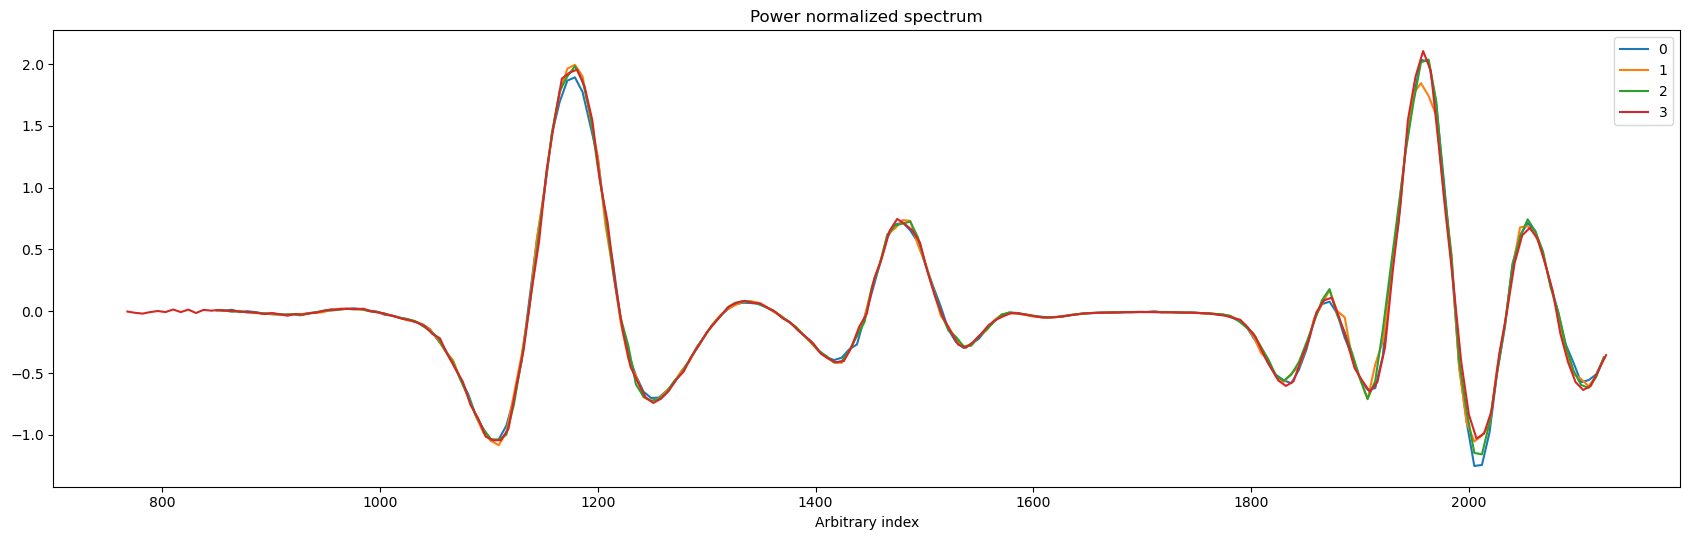

In [ ]:
path_22_deg = "./datas/22deg/"
cm_22deg_600 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_600_.+", cols=col_names)
cm_22deg_600.spectrum_only_plot()

# cm_22deg_600.spectra_list[0]

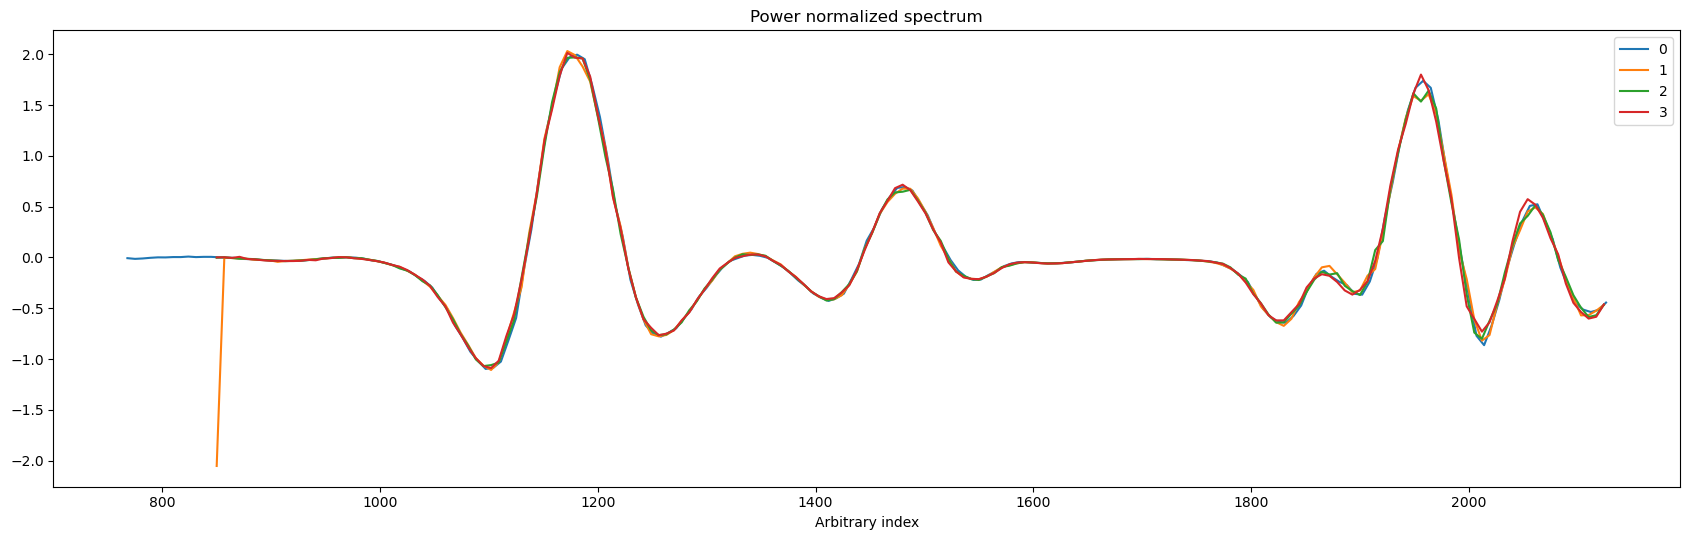

In [ ]:
path_22_deg = "./datas/22deg/"
cm_22deg_900 = CEPAS_measurement(path=path_22_deg, path_signature="gasx_900_.+", cols=col_names)
cm_22deg_900.spectrum_only_plot()

## Short `scipy.signal.find_peaks()` tutorial

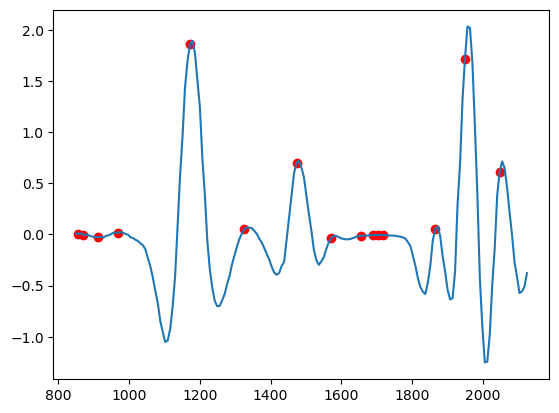

,time,offset1,P1,H3,H2,P_las,T_las,RH,Pressure,time_subtracted,H2_pnorm,H3_pnorm
1,6590.055,850.0,0.0,0.000324,0.000260,0.026218,295.1688,26.80664,599.0,0.000,0.009040,0.011296
2,6605.331,857.0,0.0,0.000344,0.000148,0.027235,295.2090,26.80664,599.0,15.276,0.004961,0.011565
3,6606.654,864.0,0.0,0.000075,0.000352,0.027682,295.2151,26.80664,599.0,16.599,0.011652,0.002496
4,6608.095,871.0,0.0,-0.000136,-0.000227,0.028417,295.2239,26.80664,599.0,18.040,-0.007347,-0.004389
5,6609.316,878.0,0.0,-0.000544,0.000005,0.029041,295.2076,26.80664,599.0,19.261,0.000167,-0.017233
...,...,...,...,...,...,...,...,...,...,...,...,...
179,6996.772,2096.0,0.0,-0.041306,-0.069222,0.164323,295.1929,26.75781,599.0,406.717,-0.414943,-0.247603
180,6998.101,2103.0,0.0,-0.053611,-0.096194,0.165167,295.1901,26.75781,599.0,408.046,-0.573719,-0.319746
181,7013.579,2110.0,0.0,-0.059140,-0.094015,0.166118,295.2088,26.75781,597.0,423.524,-0.557564,-0.350733
182,7014.904,2117.0,0.0,-0.052258,-0.086383,0.166520,295.2178,26.70898,597.0,424.849,-0.511079,-0.309180


In [ ]:
test_peaks, _ = find_peaks(cm_22deg_600.spectra_list[0]['H2_pnorm'])
df = cm_22deg_600.spectra_list[0]
f = lambda x: x if x.name in test_peaks else None  # noqa: E731
df_peaks = df.apply(f, axis=1, result_type='broadcast').dropna()
plt.plot(df['offset1'], df['H2_pnorm'])
plt.scatter(df_peaks['offset1'], df_peaks['H2_pnorm'], c='red')
plt.show()
# test_peaks[0]
# df.loc[1,:]
# df_peaks
df

## Modulation amplitude test for line $\tilde{\nu}_{\text{H}_2\text{O}}=6983.6678\ \text{cm}^{-1}$

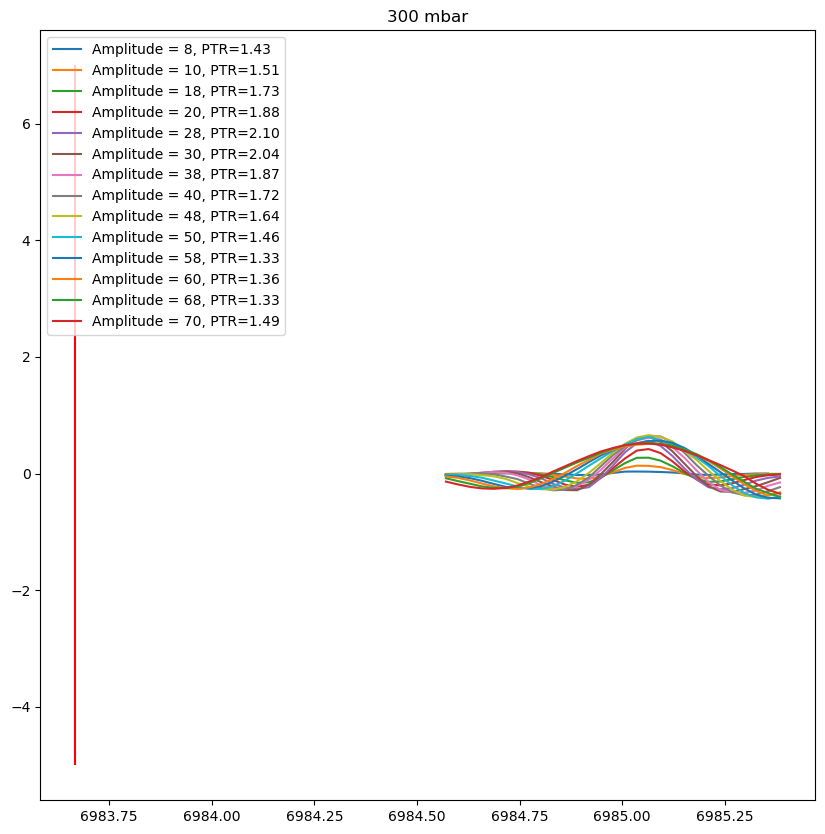

In [ ]:
path_6983_6678_300 = "./datas/amptests/h2o_6983_6678/"
amp_test_6983_6678_300_dict = {}
amp_list = [hex(8+i*8)[2:] for i in range(14)]
amp_test_plot("300", path_6983_6678_300, amp_test_6983_6678_300_dict, amp_list, 6983.6678)

# Whiteboard

In [ ]:
diff88_8 = subtract_hex("00088", "00008")
int(diff88_8, 16)/8

16.0

In [ ]:
# %matplotlib widget
def f(x):
    return x

interact(f, x=10)



interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>

In [ ]:
np.round(np.geomspace(32, 300, 9, endpoint=True))

array([ 32.,  42.,  56.,  74.,  98., 130., 171., 227., 300.])

# Misc

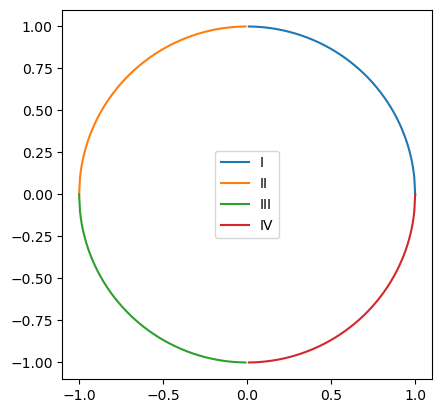

In [ ]:
plt.gca().set_aspect('equal')
r = 1
A = np.pi * r**2
x_arr = np.linspace(0.01, 1, 200)
def circle(x, r=1.0):
    expression = r - np.pow(x, 2)
    return np.sqrt(expression)

# print(x_arr)

plt.plot(x_arr, circle(x_arr, r), label="I")
plt.plot(-x_arr, circle(x_arr, r), label="II")
plt.plot(-x_arr, -circle(x_arr, r), label="III")
plt.plot(x_arr, -circle(x_arr, r), label="IV")
plt.legend()
plt.show()

In [ ]:
area_test, err = quad(circle, 0, 1, args=(1,))
print(round(4*area_test, 14))
print(round(np.pi, 14))


3.14159265358979
3.14159265358979


In [ ]:
def custom_integral(f, x1, x0=0, step_denominator=1e6):
    dx = 1/step_denominator
    x_values = np.linspace(x0+dx, x1, int(step_denominator))
    return np.sum(f(x_values, x1)*dx)

4*custom_integral(f=circle, x1=1.0)

np.float64(3.1415906524138117)